# Banxico Parte 2:

* Ocupando **únicamente** pandas, numpy; matplotlib; seaborn, con la información obtenida en la parte 1 (pandas DataFrame) modelar con Naïve Bayes si un documento dado pertence a la clase `mantiene`, `sube`, `baja`

## Pasos
1. Descargar PDFs
2. Limpiar los datos
3. Eliminar de todos los archivo las palabras que contengan `mantiene`, `sube`, `baja`.
4. Parte los documentos entre un set de entrenamiento (0.8) y uno de prueba (0.2)
5. Entrena el modelo con los documentos de entrenamiento y valida el resultado con una matriz de confusión usado la base de prueba

# Proyecto

Librerias requeridas:

In [43]:
import pandas as pd
import functools
from requests_html import HTMLSession
import requests
from PyPDF2 import PdfFileReader
import io
from unidecode import unidecode
import re
from nltk import corpus
import nltk
from collections import defaultdict,Counter
import numpy as np
import seaborn as sns

### Funciones útiles

En esta sección se presentan las funciones que se utilizaran a lo largo del notebook tanto para el proceso y manejo de información como para la implementación del modelo. **Es importante mencionar que se busco minimizar el uso de librerias que no fueran las que se mencionó en las instrucción del proyecto**

In [2]:
def clean_text(text):
    """
    Función que limpia una cadena de texto
    in:
        text: cadena de texto
    out     
        text_a: cadena de texto limpia 
    """
    text = unidecode(text)
    text = text.lower()
    text = re.sub("[^\w ]","",text)
    text = re.sub("[\d]","",text)
    text = re.sub("dismin\w+|manten\w+|incremen\w+|aument\w+","",text)
    text_a = text.lstrip().rstrip()
    return text_a

In [3]:
def get_text_pdf(url):
    """
    Función que obtiene el texto de un pdf
    in:
        url: url de donde se ubica el pdf a trabajar
    out:
        text: cadena de texto 
    """
    response = requests.get(url)
    with io.BytesIO(response.content) as f:
        pdf = PdfFileReader(f)
        text = ''
        number_of_pages = pdf.getNumPages()
        for i in range(number_of_pages):
            text += pdf.getPage(i).extractText()
        
    return text

In [4]:
#nltk.download('stopwords')
def text2dict(text):
    """
    Función que transforma un texto en un diccionario de palabras junto con su frecuencia
    in: 
        text: cadena de texto
    out:
        dict_re : diccionario con frecuencias
        m: longitud del diccionario
    """
    stopwords = corpus.stopwords.words("spanish")
    stopwords = [unidecode(word) for word in stopwords] 
    dict_t = [word for word in re.sub("[0-9]","",text).split() if word not in stopwords]
    m = len(set(dict_t))
    dict_re = dict(Counter(dict_t))
    return dict_re, m

In [5]:
def train_test(df, size = 0.7):
    """
    Función que divide en entrenamiento y test un dataframe con base en la proporción señalada
    in:
        df: dataframe
        size: proporción de entrenamiento
    out:
        df_train: dataframe de entrenamiento
        df_test: dataframe de test
    """
    n = df.shape[0]
    m = int(np.round(n * size))
    sub = np.random.choice(range(n), size = m, replace = False)
    sub_t = ~df.index.isin(df.iloc[sub].index)
    
    df_train = df.iloc[sub] 
    df_test = df.iloc[sub_t]
    return df_train, df_test 

In [6]:
def get_df2train(df, columns = 'category'):
    """
    Función que obtiene un dataframe con frecuencias de palabras para ciertas clases
    in:
        df: dataframe
        columns: columna categorica respecto a la cual se contaran las clases
    out:
        dfs: dataframe con frecuencias de palabras por clase
        lengths: diccionario con la longitud de palabras de cada clase
    """
    categories = set(df[columns])
    dfs = pd.DataFrame()
    lengths = {}
    for j in categories:
        texto_completo = ''
        for i in df[df[columns]== j]['url'].values:
            text = get_text_pdf(i) 
            texto = clean_text(text)
            texto_completo += texto + ' '

        dict_inc, leng = text2dict(texto_completo)
        lengths[j] = leng
        dfs = dfs.join(pd.DataFrame.from_dict(dict_inc,orient="index",columns=[j]), how = 'outer').fillna(0) +1 
    return dfs, lengths

In [7]:
class NaiveBayes:
    """Clase que implementa el calculo de las probabilidades a posterior 
            partiendo de los supuestos del modelo de naive bayes
    """
    def __init__(self, priors = None, verosimilitud = None, log = True):
        self.dataset = None
        if log:
            self.priors = priors
            self.verosimilitud = verosimilitud
            
        else:
            self.priors = self.__tolog__(priors)
            self.verosimilitud = self.__tolog__(verosimilitud)
            
    def setPriors(self, priors, log = True):
        if log:
            self.priors = priors
        else:
            self.priors = self.__tolog__(priors)
    
    def getPriors(self): 
        return self.priors
    
    def setVerosimilitud(self, verosimilitud, log = True):
        if log:
            self.verosimilitud = verosimilitud
        else:
            self.verosimilitud = self.__tolog__(verosimilitud)
    
    def getVerosimilitud(self):
        return self.verosimilitud
    
    def getDataset(self):
        return self.dataset
    
    def __tolog__(self, df):
        df = np.log(df)
        return df
    
    def predict(self, diccion):
        predict_value = (self.getVerosimilitud().loc[diccion].sum(axis=0) + + self.getPriors()['n']).idxmax()
        return predict_value

In [33]:
def predict_pdf(df, model):
    """
    Función que predice el tipo de politica monetaria de un comunicado de Banxico
    in:
        df: dataframe
        model: instancia de la clase naiveBayes 
    out:
        df: dataframe con 
    """
    preds = []
    for i in df['url'].values:
        text = get_text_pdf(i) 
        texto = clean_text(text)

        dict_inc, leng = text2dict(texto)
        words = list(dict_inc.keys())
        words = [word for word in words if word in list(naivebayes.getVerosimilitud().index)]
        preds.append(model.predict(words))
    df['predictions'] = preds
    return df

In [40]:
def validacion(test, pred):
    """
    Función que calcula algunas metricas de performance para un modelo de clasificación
    """
    matrix = pd.crosstab(test, pred)
    print(matrix)
    print('-----------------------------------')
    print('-----------Precision---------------')
    print(np.diag(matrix.values) / matrix.sum(axis = 0))
    print('-----------------------------------')
    print('--------------Recall---------------')
    print(np.diag(matrix.values) /matrix.sum(axis = 1))
    
    return matrix

## 1 Lectura de información

In [9]:
df = pd.read_pickle("comunicados-banxico.pkl")
df.head()

,text,url,category,y
fecha,,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa,1


Separamos nuestro conjunto de documentos en train y test para empezar

In [10]:
train, test = train_test(df, 0.8)

## 2 Lectura de pdf, limpieza de datos y transformación de datos

Para entrenar el modelo necesitamos leer el pdf y limpiar los datos, primero para la parte del train y posteriormente, con las mismas funciones, para el test

*Ejemplo para un pdf*

In [11]:
url = train['url'][0]

In [13]:
text = get_text_pdf(url) 
texto = clean_text(text)

In [14]:
texto

'de febrero de  comunicado de prensa  anuncio de politica monetaria la junta de gobierno del banco de mexico ha decidido  en  por ciento el objetivo para la tasa de interes interbancaria a un dia  la economia global se ha recuperado a un ritmo mayor al esperado aunque la velocidad de recuperacion ha sido diferente entre regiones lo anterior ha llevado a una revision al alza de las expectativas de crecimiento mundial para el  en particular se espera un mayor crecimiento anual del pib y de la produccion industrial en los estados unidos sin embargo aun se preve que los niveles de actividad economica se  por debajo de su potencial por algun tiempo se anticipa que en la mayoria de los paises tanto avanzados como emergentes la inflacion continue relativamente baja a pesar de que en algunos ya se ha presentado un repunte en los indices generales de precios en este contexto es previsible que la postura monetaria se  acomodaticia a nivel mundial si bien algunas economias ya han empezado a rever

In [15]:
text2dict(texto)

({'febrero': 1,
  'comunicado': 1,
  'prensa': 1,
  'anuncio': 1,
  'politica': 1,
  'monetaria': 3,
  'junta': 3,
  'gobierno': 2,
  'banco': 2,
  'mexico': 3,
  'decidido': 2,
  'ciento': 4,
  'objetivo': 1,
  'tasa': 2,
  'interes': 2,
  'interbancaria': 2,
  'dia': 2,
  'economia': 3,
  'global': 1,
  'recuperado': 1,
  'ritmo': 1,
  'mayor': 5,
  'esperado': 2,
  'aunque': 3,
  'velocidad': 1,
  'recuperacion': 2,
  'sido': 3,
  'diferente': 1,
  'regiones': 1,
  'anterior': 3,
  'llevado': 1,
  'revision': 2,
  'alza': 1,
  'expectativas': 3,
  'crecimiento': 2,
  'mundial': 2,
  'particular': 3,
  'espera': 1,
  'anual': 1,
  'pib': 2,
  'produccion': 1,
  'industrial': 3,
  'unidos': 1,
  'embargo': 2,
  'aun': 1,
  'preve': 1,
  'niveles': 3,
  'actividad': 4,
  'economica': 1,
  'debajo': 2,
  'potencial': 2,
  'algun': 1,
  'tiempo': 1,
  'anticipa': 2,
  'mayoria': 2,
  'paises': 1,
  'avanzados': 1,
  'emergentes': 1,
  'inflacion': 9,
  'continue': 1,
  'relativamente': 1

### Train

En este paso se implementa de manera general para todos los documentos dentro del *train*, los pasos para la **descarga, limpieza y transformación de los datos para implementar el modelo naive bayes**

In [19]:
dfs, priors = get_df2train(train)

Obteniendo un dataframe de frecuencias por palabra para cada clase o categoria a clasificar

In [20]:
dfs

,mantiene,incrementa,disminuye
abastecimiento,4.0,2.0,1.0
abasto,5.0,2.0,2.0
abatimiento,4.0,2.0,2.0
abatir,6.0,2.0,4.0
abierto,6.0,2.0,1.0
...,...,...,...
vuelva,5.0,2.0,1.0
vulnerabilidad,8.0,2.0,1.0
vulnerabilidades,10.0,3.0,3.0
yen,4.0,2.0,1.0


In [21]:
dfs_t = dfs / dfs.sum(axis = 0)
dfs_t

,mantiene,incrementa,disminuye
abastecimiento,0.000110,0.000151,0.000113
abasto,0.000137,0.000151,0.000226
abatimiento,0.000110,0.000151,0.000226
abatir,0.000164,0.000151,0.000451
abierto,0.000164,0.000151,0.000113
...,...,...,...
vuelva,0.000137,0.000151,0.000113
vulnerabilidad,0.000219,0.000151,0.000113
vulnerabilidades,0.000274,0.000227,0.000338
yen,0.000110,0.000151,0.000113


Obtenemos el vector de probabilidades a priori de cada clase/categoria

In [22]:
priors_n = pd.DataFrame.from_dict(priors, orient = 'index', columns = ['n'])

In [23]:
priors_v = priors_n / priors_n.sum()
priors_v

,n
mantiene,0.491535
incrementa,0.268024
disminuye,0.240441


## 3 Implementación del modelo

Una vez obtenidas las proporciones de frecuencias, creamos una **instancia de la clase NaiveBayes** que nos va a permitir ajustar y obtener las probabilidades a posteriori

### Ajuste

In [30]:
naivebayes = NaiveBayes(priors_v, dfs_t, log = False)

In [31]:
naivebayes.getPriors()

,n
mantiene,-0.710222
incrementa,-1.316680
disminuye,-1.425279


In [32]:
naivebayes.getVerosimilitud() 

,mantiene,incrementa,disminuye
abastecimiento,-9.119513,-8.798153,-9.090317
abasto,-8.896369,-8.798153,-8.397170
abatimiento,-9.119513,-8.798153,-8.397170
abatir,-8.714048,-8.798153,-7.704023
abierto,-8.714048,-8.798153,-9.090317
...,...,...,...
vuelva,-8.896369,-8.798153,-9.090317
vulnerabilidad,-8.426365,-8.798153,-9.090317
vulnerabilidades,-8.203222,-8.392688,-7.991705
yen,-9.119513,-8.798153,-9.090317


### Predicción

In [34]:
predicciones = predict_pdf(test, naivebayes)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [ipykernel_launcher.py:19]


In [35]:
predicciones

,text,url,category,y,predictions
fecha,,,,,
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene
2008-07-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa,1,mantiene
2008-10-17,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene
2009-02-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,disminuye,-1,disminuye
2010-03-19,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene
2010-05-21,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene
2010-10-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene
2011-05-27,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene
2012-06-08,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene,0,mantiene


## 4 Validacion

Por ultimo agregamos, ejecutamos algunas métricas para medir el performance del modelo

In [41]:
aux = validacion(predicciones['category'],predicciones['predictions'])

predictions  disminuye  incrementa  mantiene
category                                    
disminuye            2           0         0
incrementa           0           2         4
mantiene             1           0        12
-----------------------------------
-----------Precision---------------
predictions
disminuye     0.666667
incrementa    1.000000
mantiene      0.750000
dtype: float64
-----------------------------------
--------------Recall---------------
category
disminuye     1.000000
incrementa    0.333333
mantiene      0.923077
dtype: float64


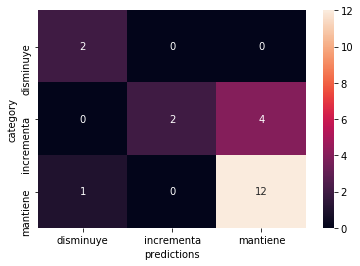

In [42]:
sns.heatmap(aux, annot=True, fmt="d")

**Conclusiones** :Se puede observar que a la clase que peor le cuesta clasificar es a la incrementa, pues solo clasifica correctamente el 12% de las veces. Para la clase mantiene paso algo que no se busca, pues aunque el recall es el mayor de todos, la precisión de este es muy baja por lo que estamos prediciendo muchos falsos positivos. Se puede concluir que este modelo en general es muy malo y deben de hacer adecuaciones.